# Model training advanced

Sleep scoring under different combinations of PSG channels for softmax, ANN, DNN and CNN network models.

## Notebook initialization

In [1]:
%autosave 0
%matplotlib notebook

from __future__ import division, print_function
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import pyedflib
                                                                                                                                                                                                                                        
fig_w, fig_h = (4.5, 3.5)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

import keras

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = '0'
set_session(tf.Session(config=config))

Autosave disabled


Using TensorFlow backend.


## Configuration settings

In [2]:
import mod_edf

path_folder = '/share/datasets/sleep-edfx/'

edf_ids_excluded =  ['SC4061', 'ST7071', 'ST7092', 'ST7132', 'ST7141', 'SC4131', 'ST7201',
                     'ST7011',  'ST7041', 'ST7101', 'ST7121', 'ST7151', 'ST7171', 'ST7241' ]

channels_ref = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

channels_ref_short = ['EEG1', 'EEG2', 'EOG', 'EMG']

metric_short = {'loss': 'loss', 'categorical_accuracy': 'acc'}

freq_target = 60

awake_pre_post = 10

batch_size = 128
epochs = 30
n_val = 300

channel_masks = [[True, True, True, True], [True, False, False, False], [False, True, False, False],
                 [False, False, True, False], [False, False, False, True], [True, True, False, False],
                 [True, False, True, False], [True, False, False, True], [False, True, True, False],
                 [False, True, False, True], [False, False, True, True], [True, True, True, False], 
                 [True, True, False, True], [True, False, True, True], [False, True, True, True]]



## Import dataset

Polysomnography (PSG) records are imported from edf files into the dictionary `dataset` with record filenames as keys.

Each record contains a dictionary with the following entries:

* `hypnogram` the hypnogram as an array of shape `(epochs, 1)`
* `signals` the PSG channels as a list of arrays of shape `(epochs, samples, 1)` , or an array of shape `(epochs, samples, channels)`
* `channels` the names of the PSG channels as a list
* `freqs` the frequencies of the PSG channels a list

In [3]:
# get list of filenames of first time subjects

edf_first_night = [item for item in os.listdir(path_folder)
                  if (os.path.splitext(item)[1]).lower()=='.edf' and item[5]=='1' ]


edf_ids = set([item[:6] for item in edf_first_night
                        if item[:6]not in edf_ids_excluded])
psg_files, hyp_files = ([], [])

for edf_id in sorted(edf_ids):
    
    psg_files += [[os.path.join(path_folder, item) for item in edf_first_night
                     if (item[:6]==edf_id and item.endswith('-PSG.edf'))][0]]

    hyp_files += [[os.path.join(path_folder, item) for item in edf_first_night
                     if (item[:6]==edf_id and item.endswith('-Hypnogram.edf'))][0]]

print(len(psg_files), 'psg and', len(hyp_files), 'hypnograms found')

20 psg and 20 hypnograms found


In [4]:
# import dataset from list of filenames
dataset = mod_edf.load_sleep_edf(psg_files, hyp_files, channels_ref=channels_ref)

opening 20 records 

 SC4001E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4011E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4021E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4031E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4041E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4051E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4071E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4081E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4091E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4101E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizon

In [5]:
dataset_records = sorted(dataset.keys())

record_ref = dataset_records[0]

dataset_record_ref = {item: dataset[record_ref][item] for item in dataset[record_ref]}

dataset_channels = dataset_record_ref['channels']

dataset_channels_short = [channels_ref_short[idx_channel]
                          for idx_channel, channel in enumerate(dataset_channels)]

## Data pre-processing

Several pre-processing steps are applied to the dataset prior to model training.

### Awake state event reduction

Sleep records may have important amounts of awake states in the beginning and end of the sessions. In order to reduce such frequency bias, these states are often removed up to 5 minutes before/after the first/last non awake sleep state.

In [6]:
for record in dataset:
    
    hyp = dataset[record]['hypnogram']
    
    idx_start = max(0, np.where(hyp!=0)[0][0] - awake_pre_post)
    idx_end = min(np.where(hyp!=0)[0][-1] + awake_pre_post, hyp.shape[0])
    
    dataset[record]['hypnogram'] = dataset[record]['hypnogram'][idx_start:idx_end]
    
    for idx_channel in range(len(dataset[record]['channels'])):
        
        dataset[record]['signals'][idx_channel] =  dataset[record]['signals'][idx_channel][idx_start:idx_end]

<IPython.core.display.Javascript object>


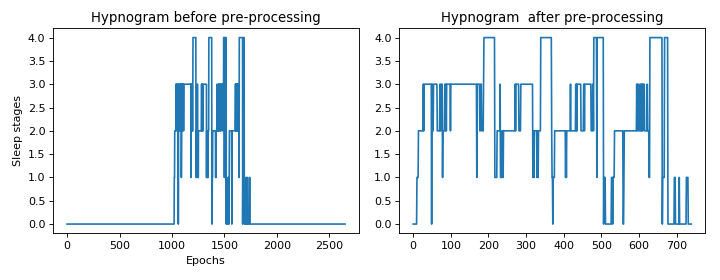

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(2*fig_w,fig_h))

plt.sca(axs[0])
hypno = dataset_record_ref['hypnogram']
plt.plot(dataset_record_ref['hypnogram'], label='pre')
plt.xlabel('Epochs')
plt.ylabel('Sleep stages')
plt.title('Hypnogram before pre-processing')

plt.sca(axs[1])
hypno = dataset[record_ref]['hypnogram']
plt.plot(hypno, label='pre')
plt.title('Hypnogram  after pre-processing')

plt.tight_layout()
fig.canvas.draw()

### Re-sample dataset to target frequency

The PSG records may contain channels sampled at different sampling rates and it may be necessary to set a global sampling rate and upsample or downsample channels accordingly. Downsampling PSG records has computational advantages by reducing the number of operations per mini-batch, and implements a natural low pass filter (at half the target frequency). Several studies indicate that low frequencies are the most relevant to sleep scoring.

In [8]:
from scipy import signal

def gcd(a, b):

    return gcd(b, a % b) if b else a

def updown(n1, n2):

    div = gcd(n1,n2)

    return (n2//div, n1//div)

In [9]:
# print unique frequencies in dataset

verbose = False

freqs = []
for record in dataset:
    freqs += dataset[record]['freqs']
    
print('(pre) unique frequencies in dataset', sorted(set(freqs)))

# resample dataset to target frequency
for record in dataset:
    
    for idx_channel, channel in enumerate(dataset[record]['channels']):
    
        freq = dataset[record]['freqs'][idx_channel]
        
        if freq!=freq_target:
            
            up, down = updown(freq, freq_target)
            
            data = dataset[record]['signals'][idx_channel]

            data_d = sp.signal.resample_poly(np.concatenate(data, axis=0), up, down)
            
            dataset[record]['signals'][idx_channel] = np.array(np.split(data_d , data.shape[0]))
            dataset[record]['freqs'][idx_channel] = freq_target
            
            if verbose:
                
                print(record, channel, freq, '->', freq_target)
        
# print unique frequencies in dataset

freqs = []
for record in dataset:
    freqs += dataset[record]['freqs']
    
print('(post) unique frequencies in dataset', sorted(set(freqs)))

(pre) unique frequencies in dataset [1.0, 100.0]


/share/anaconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


(post) unique frequencies in dataset [60]


### Stack PSG channels into numpy array

This is now possible since all channels have the same sampling frequency.

In [10]:
for record in sorted(dataset):
    
    if type(dataset[record]['signals'])==type(list()):
        dataset[record]['signals']= np.stack(dataset[record]['signals'], axis=2)

    print('sample record\t', record)
    print('PSG channels shape:\t', dataset[record]['signals'].shape)
    print('hypnogram shape:\t', dataset[record]['hypnogram'].shape)

sample record	 SC4001E
PSG channels shape:	 (740, 1800, 4)
hypnogram shape:	 (740, 1)
sample record	 SC4011E
PSG channels shape:	 (1002, 1800, 4)
hypnogram shape:	 (1002, 1)
sample record	 SC4021E
PSG channels shape:	 (924, 1800, 4)
hypnogram shape:	 (924, 1)
sample record	 SC4031E
PSG channels shape:	 (851, 1800, 4)
hypnogram shape:	 (851, 1)
sample record	 SC4041E
PSG channels shape:	 (1135, 1800, 4)
hypnogram shape:	 (1135, 1)
sample record	 SC4051E
PSG channels shape:	 (571, 1800, 4)
hypnogram shape:	 (571, 1)
sample record	 SC4071E
PSG channels shape:	 (875, 1800, 4)
hypnogram shape:	 (875, 1)
sample record	 SC4081E
PSG channels shape:	 (1033, 1800, 4)
hypnogram shape:	 (1033, 1)
sample record	 SC4091E
PSG channels shape:	 (1042, 1800, 4)
hypnogram shape:	 (1042, 1)
sample record	 SC4101E
PSG channels shape:	 (1004, 1800, 4)
hypnogram shape:	 (1004, 1)
sample record	 SC4111E
PSG channels shape:	 (828, 1800, 4)
hypnogram shape:	 (828, 1)
sample record	 SC4121E
PSG channels shape:	 

### Normalize PSG data

Network models often work better after centering and scaling training data, either globaly or at mini-batch level.

In [11]:
def normalization(u):
    """Remove channel mean from array u and devide by standard deviation.
   u: array with shape (channel, batch, data)
   returns u_out: array u with zero channel mean and devided by standard deviation
    """
    u_out = u.copy()

    for idx in range(u_out.shape[2]):
        u_out[:,:,idx] = (u_out[:,:,idx] - np.mean(u_out[:,:,idx],keepdims=True))/(np.std(u_out[:,:,idx]))
    
    return u_out

In [12]:
dataset[record]['signals'] = normalization(dataset[record]['signals'])

## Model training

### Model input/output conversion functions
Function `to_input()` converts PSG channels into vector representation, with optional selection of channels by boolean array.

Function `to_output()` converts sleep scores into `one-hot-encoding`, i.e. score `0` to `[1 0 0 0 0]`, score `1` to  `[0 1 0 0 0]`, etc.

In [13]:
from keras.utils import Sequence
from time import time
import random

def to_input(u, tensor=True, channel_mask=None):
    """Convert data array to shape (batch, data).
    u: array with shape (batch, samples, channels)
    channel_mask: boolean mask of channels to include
    
    returns x_out: array x with shape (batch, samples*selected_channels) if tensor is False
                   array x with shape (batch, samples, selected_channels, 1) if tensor is True"""
    if channel_mask:
        
        u_out = u[:,:, channel_mask]
        
    else:
        
        u_out = u
    
    if tensor:
        u_out = u_out.reshape((u_out.shape[0], u_out.shape[1], u_out.shape[2], 1))
        
    else:
        u_out = u_out.reshape((u_out.shape[0], u_out.shape[1]*u_out.shape[2]))
    
    return u_out


def to_output(u, num_classes=5):
    """Convert label array to one-hot-encoding with shape (batch, binary_label).
    u: label array with shape (batch, 1)
    
    returns: u_out (array with shape (batch, binary_label))"""
    
    #convert a float class array to binary class array
    u_out = keras.utils.to_categorical(u, num_classes=num_classes)
    
    return u_out


class PSGSequence(Sequence):
    
    def __init__(self, dataset, records=None, epochs_selected=None, batch_size=256,
                 tensor=False, channel_mask=None, process_input=to_input, process_output=to_output):
    
        self.dataset = dataset
        self.records = records
        self.epochs_selected = epochs_selected
        self.batch_size = batch_size
        self.tensor = tensor
        self.channel_mask = channel_mask
        self.process_input = process_input
        self.process_output = process_output

        if self.records is None:

            self.records = list(self.dataset.keys())
            self.epochs_selected = None

        if self.epochs_selected is None:

            self.epochs_selected = [np.array([True]*self.dataset[record]['hypnogram'].shape[0])
                                    for record in self.records]

        self.record_epoch = []
        for idx_record, record in enumerate(self.records):
            selected = self.epochs_selected[idx_record]
            for epoch in np.arange(len(selected))[selected]:
                self.record_epoch += [[record, epoch]]
                                
        self.on_epoch_end()
                                
        self.epochs_n = len(self.record_epoch)
        
        x_batch, y_batch = self.__getitem__(0)
        
        self.x_batch_shape = x_batch.shape
        self.y_batch_shape = y_batch.shape
        
    def on_epoch_end(self):
        
        random.shuffle(self.record_epoch)
        
    def __len__(self):
        
        return int(np.ceil(self.epochs_n / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        record_epoch_batch =  self.record_epoch[idx * self.batch_size:(idx + 1) * self.batch_size]
                                
        x_batch, y_batch = ([],[])
        
        for record, epoch in record_epoch_batch:
            
            x_batch += [self.dataset[record]['signals'][epoch]]
            y_batch += [self.dataset[record]['hypnogram'][epoch]]
                   
        return self.process_input(np.array(x_batch), tensor=self.tensor, channel_mask=self.channel_mask), \
            self.process_output(np.array(y_batch))
    
    
def epochs_train_val(dataset, records, size):
    
    epochs_train, epochs_val = ([], [])

    for record in records:

        epochs_selected = np.array([False]*dataset[record]['hypnogram'].shape[0])
        idx = np.random.choice(epochs_selected.shape[0], size=size, replace=False) 
        epochs_selected[idx] = True

        epochs_val += [epochs_selected]
        epochs_train += [~epochs_selected]
        
    return epochs_train, epochs_val

### Example train/test split for testing model setup

In [14]:
records_test = [dataset_records[0]]
records_train = dataset_records[1:]


epochs_train, epochs_val = epochs_train_val(dataset, records_train, n_val)


generator_train_cnn = PSGSequence(dataset, 
                                  records=records_train, 
                                  epochs_selected=epochs_train, 
                                  batch_size=batch_size,
                                  tensor=True)

generator_val_cnn = PSGSequence(dataset, 
                                records=records_train, 
                                epochs_selected=epochs_val,
                                batch_size=batch_size,
                                tensor=True)

generator_test_cnn = PSGSequence(dataset, 
                                 records=records_test,
                                 batch_size=batch_size,
                                 tensor=True)


input_shape = generator_train_cnn.x_batch_shape[1:]
output_dim = generator_train_cnn.y_batch_shape[1]

print(generator_test_cnn.x_batch_shape)
print(generator_train_cnn.x_batch_shape)
print(generator_val_cnn.x_batch_shape)

(128, 1800, 4, 1)
(128, 1800, 4, 1)
(128, 1800, 4, 1)


### CNN model
CNN model with multiple convolutional / max pool layers, ReLU units and softmax output.

The function `model_cnn()` returns the compiled model using adadelta optimizer, binary crossentropy loss and categorical accuracy metric.

In [16]:
from keras import Input, Model
from keras.layers import Dense, Layer
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD


def model_cnn(input_shape=(1800,4,1), output_dim=5, 
              c_size=[32, 16, 8], k_size=[3, 3, 3], h_dim=[128, 32], d_p=[0.5, 0.5]):
    """Define CNN model
    returns model_cnn : CNN Keras model
    """

    m = Sequential()
    m.add(Layer(input_shape=input_shape, name='input'))
    m.add(BatchNormalization())
    
    for idx_n, n in enumerate(c_size):
        
        m.add(Conv2D(n, (k_size[idx_n], 1), padding='same', activation='relu', name='c_'+str(idx_n+1)))
        m.add(BatchNormalization())
        m.add(MaxPooling2D((2, 1), padding='same', name='p_'+str(idx_n+1)))
    m.add(Dropout(0.5))
    
    m.add(Flatten(name='flatten'))
    m.add(BatchNormalization())
              
    for idx_n, n in enumerate(h_dim):
        m.add(Dense(n, activation='relu', name='h_'+str(idx_n+len(c_size)+1)))
        m.add(BatchNormalization())
        m.add(Dropout(d_p[idx_n], name='d_'+str(idx_n+len(c_size)+1)))
    
            
    m.add(Dense(output_dim, activation='softmax', name='output'))
    m.add(BatchNormalization())
    
    m.compile(loss='binary_crossentropy',
              metrics=['categorical_accuracy'],
              optimizer='adadelta')
              
    
    
    m.name = 'cnn'
          
    return m

model_cnn(input_shape, output_dim).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Layer)                (None, 1800, 4, 1)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1800, 4, 1)        4         
_________________________________________________________________
c_1 (Conv2D)                 (None, 1800, 4, 32)       128       
_________________________________________________________________
batch_normalization_10 (Batc (None, 1800, 4, 32)       128       
_________________________________________________________________
p_1 (MaxPooling2D)           (None, 900, 4, 32)        0         
_________________________________________________________________
c_2 (Conv2D)                 (None, 900, 4, 16)        1552      
_________________________________________________________________
batch_normalization_11 (Batc (None, 900, 4, 16)        64        
__________

### Train CNN model

In [29]:
epochs = 30
model = model_cnn(input_shape, output_dim)

print('model', model.name,'\n')

time_start = time()
cnn_history = model.fit_generator(generator_train_cnn, epochs=epochs)
                  
print('\ntraining for', '{0:.2f}'.format(time()-time_start), 's')

metrics_val = model.evaluate_generator(generator_val_cnn)
metrics_test = model.evaluate_generator(generator_test_cnn)

print()

for idx_metric, metric in enumerate(model.metrics_names):
    
    print(metric_short[metric], '\t\tval', '{0:.2f}'.format(metrics_val[idx_metric]),
          '\ttest', '{0:.2f}'.format(metrics_test[idx_metric]))

model cnn 

Epoch 1/30
98/98 [==============================] - 11s 114ms/step - loss: 3.8651 - categorical_accuracy: 0.2520
Epoch 2/30
98/98 [==============================] - 8s 77ms/step - loss: 3.5352 - categorical_accuracy: 0.2934
Epoch 3/30
98/98 [==============================] - 7s 77ms/step - loss: 3.3458 - categorical_accuracy: 0.3238
Epoch 4/30
98/98 [==============================] - 8s 77ms/step - loss: 3.2637 - categorical_accuracy: 0.3270
Epoch 5/30
98/98 [==============================] - 8s 77ms/step - loss: 3.1496 - categorical_accuracy: 0.3437
Epoch 6/30
98/98 [==============================] - 7s 76ms/step - loss: 2.9288 - categorical_accuracy: 0.3800
Epoch 7/30
98/98 [==============================] - 7s 76ms/step - loss: 2.7596 - categorical_accuracy: 0.4023
Epoch 8/30
98/98 [==============================] - 8s 77ms/step - loss: 2.6013 - categorical_accuracy: 0.4327
Epoch 9/30
98/98 [==============================] - 8s 77ms/step - loss: 2.4090 - categorical_accu

<IPython.core.display.Javascript object>


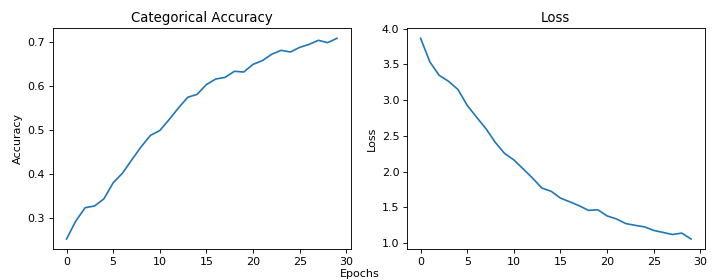

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(2*fig_w,fig_h))

plt.sca(axs[0])
plt.plot(cnn_history.history['categorical_accuracy'])

plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')

plt.sca(axs[1])
plt.plot(cnn_history.history['loss'])
plt.ylabel('Loss')
plt.title('Loss')

plt.tight_layout()
fig.text(0.5, 0.01,'Epochs', ha='center')
fig.canvas.draw()

## Cross-validation evaluation
### Cross-validation function

Estimate model performance on unseen data with function `cross_validation()` that implements *leave-one-out cross validation*. In this  performance evaluation scheme the original dataset is split in `K` sets or *folds*. The model is succesfully trained in `K-1` sets and tested on the remaining set. In this case, a set corresponds to a database.

In [17]:
epochs = 30
def cross_validation(dataset,
                     model_ref,
                     tensor=False,
                     channel_mask=None,
                     epochs=epochs, 
                     batch_size=batch_size,
                     n_val=300,
                     verbose=True):
    """Leave-one-out cross validation scheme at database level
    dataset: dataset containing records with PSG data and hypnograms
    hyp_files: list containing hypnograms of edf databases
    model_ref: Keras model
    epochs: number of training epochs
    batch_size : number of mini-batch samples
    verbose: print intermediate results otherwise no output
    
    returns models: list with trained Keras models
            metrics: list with validation and test accuracy"""
        
    if verbose:
        
        print('model', model_ref().name, '-', len(dataset), 'fold cross-validation\n')
    
    models, metrics = ([], [])
    
    for idx_record, record in enumerate(dataset_records):
        
        records_test = [record]
        records_train = [key for key in dataset_records if key not in records_test]

        epochs_train, epochs_val = epochs_train_val(dataset, records_train, n_val)

        generator_train = PSGSequence(dataset, 
                                      records=records_train, 
                                      epochs_selected=epochs_train, 
                                      batch_size=batch_size,
                                      tensor=tensor,
                                      channel_mask=channel_mask)

        generator_val = PSGSequence(dataset, 
                                    records=records_train, 
                                    epochs_selected=epochs_val,
                                    batch_size=batch_size,
                                    tensor=tensor,
                                    channel_mask=channel_mask)

        generator_test = PSGSequence(dataset, 
                                     records=records_test,
                                     batch_size=batch_size,
                                     tensor=tensor,
                                     channel_mask=channel_mask)
        
        if tensor:
            
            input_shape_dim = generator_train.x_batch_shape[1:]
            
        else:
            
            input_shape_dim = generator_train.x_batch_shape[1]
            
        output_dim = generator_train.y_batch_shape[1]

        model = model_ref(input_shape_dim, output_dim)
        
        history = model.fit_generator(generator_train, epochs=epochs, verbose=False)

        metrics_train = [history.history[metric] for metric in model.metrics_names]
        metrics_val = model.evaluate_generator(generator_val)
        metrics_test = model.evaluate_generator(generator_test)

        models += [model]
        
        metrics += [[metrics_train, metrics_val, metrics_test]]      
        if verbose:
            
            if idx_record==0:
                
                print('fold', '\t', 'acc train', '\t', 'acc val', '\t', 'acc test\n')
                
            print(idx_record+1, 
                  '\t', '{0:.2f}'.format(metrics_train[1][-1]),
                  '\t\t', '{0:.2f}'.format(metrics_val[1]),
                  '\t\t', '{0:.2f}'.format(metrics_test[1]))
            
    # shape (fold, set, metric)
    metrics = np.array(metrics)
    
    if verbose:
        
        print('\n\t', '{0:.2f} ({1:.2f})'.format(np.mean(metrics[:,0,1][-1]), np.std(metrics[:,0,1][-1])),
              '\t', '{0:.2f} ({1:.2f})'.format(np.mean(metrics[:,1,1]), np.std(metrics[:,1,1])),
              '\t', '{0:.2f} ({1:.2f})'.format(np.mean(metrics[:,2,1]), np.std(metrics[:,2,1]))) 
    return models, metrics

### Example cross-validation for softmax model

In [33]:
start_time = time()
models, metrics = cross_validation(dataset,
                                   model_cnn, 
                                   tensor=True,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   verbose=True)
print(time()-start_time)

model cnn - 20 fold cross-validation

fold 	 acc train 	 acc val 	 acc test

1 	 0.73 		 0.65 		 0.68
2 	 0.71 		 0.69 		 0.70
3 	 0.66 		 0.61 		 0.79
4 	 0.73 		 0.63 		 0.77
5 	 0.70 		 0.61 		 0.66
6 	 0.70 		 0.59 		 0.45
7 	 0.65 		 0.64 		 0.68
8 	 0.71 		 0.64 		 0.63
9 	 0.70 		 0.55 		 0.57
10 	 0.70 		 0.61 		 0.42
11 	 0.70 		 0.64 		 0.60
12 	 0.70 		 0.60 		 0.56
13 	 0.69 		 0.61 		 0.70
14 	 0.71 		 0.62 		 0.64
15 	 0.68 		 0.49 		 0.63
16 	 0.71 		 0.32 		 0.36
17 	 0.70 		 0.66 		 0.64
18 	 0.71 		 0.65 		 0.63
19 	 0.64 		 0.72 		 0.44
20 	 0.76 		 0.65 		 0.45

	 0.64 (0.12) 	 0.61 (0.08) 	 0.60 (0.12)
4580.79021406


<IPython.core.display.Javascript object>


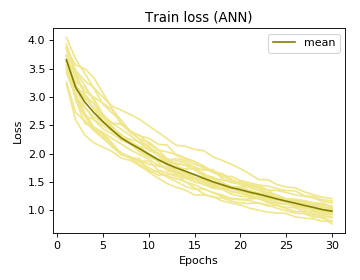

<IPython.core.display.Javascript object>


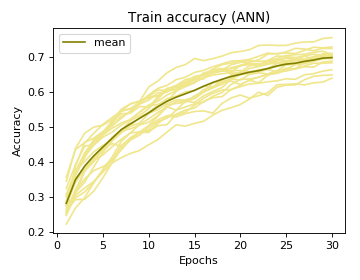

In [34]:
loss, accuracy = ([], [])

for item in metrics:
    loss += [item[0][0]]
    accuracy += [item[0][1]]
    


x_range = np.arange(epochs)+1

plt.figure()    
for item in loss:
    plt.plot(x_range, item, color='khaki')

plt.plot(x_range, np.mean(loss, axis=0), color='olive', label = 'mean')

plt.title('Train loss (ANN)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.tight_layout()

plt.figure()
for item in accuracy:
    plt.plot(x_range, item, color='khaki')

plt.plot(x_range, np.mean(accuracy,axis=0), color='olive', label = 'mean')
  
plt.title('Train accuracy (ANN)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.tight_layout()

### plot train and val accuracy

### Model CNN

In [18]:
channel_masks_names = ['_'.join(np.array(channels_ref_short)[mask]) for mask in channel_masks]

models_masks, metrics_masks, model_cnn_metrics = ([] ,[], {})

time_start = time()

cnn_time2 = []

for idx_channel_mask, channel_mask in enumerate(channel_masks):
    
    print('channels', channel_masks_names[idx_channel_mask],'\n')
    
    time_start_iteration = time()
    
    models, metrics = cross_validation(dataset,
                                       model_cnn, 
                                       tensor=True,
                                       channel_mask=channel_mask,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=True)
    
    cnn_time2 += [time()-time_start_iteration]
    
        
    print('\nfor ', channel_masks_names[idx_channel_mask], ' the training lasts for ', '{0:.2f}'.format(time()-time_start_iteration), 's')
    
    
    models_masks += [models]
    metrics_masks += [metrics]
    
    model_cnn_metrics[channel_masks_names[idx_channel_mask]] = {'mean': '{0:.2f}'.format(np.mean(metrics[:,2,1])), 
                                                                    'std': '{0:.2f}'.format(np.std(metrics[:,2,1]))}
    
    print()
    
time_execution_cnn = time()-time_start

print('\ntime execution for ', '{0:.2f}'.format(time_execution_cnn), 's')



channels EEG1_EEG2_EOG_EMG 

model cnn - 20 fold cross-validation

fold 	 acc train 	 acc val 	 acc test

1 	 0.72 		 0.57 		 0.54
2 	 0.68 		 0.62 		 0.72
3 	 0.69 		 0.64 		 0.70
4 	 0.67 		 0.60 		 0.73
5 	 0.68 		 0.61 		 0.55
6 	 0.71 		 0.63 		 0.45
7 	 0.70 		 0.68 		 0.81
8 	 0.69 		 0.65 		 0.52
9 	 0.67 		 0.59 		 0.61
10 	 0.72 		 0.66 		 0.75
11 	 0.69 		 0.60 		 0.69
12 	 0.69 		 0.66 		 0.70
13 	 0.71 		 0.56 		 0.49
14 	 0.74 		 0.61 		 0.55
15 	 0.70 		 0.66 		 0.52
16 	 0.66 		 0.67 		 0.62
17 	 0.72 		 0.63 		 0.57
18 	 0.69 		 0.61 		 0.67
19 	 0.75 		 0.78 		 0.38
20 	 0.71 		 0.62 		 0.45

	 0.60 (0.13) 	 0.63 (0.05) 	 0.60 (0.11)

for  EEG1_EEG2_EOG_EMG  the training lasts for  4634.41 s

channels EEG1 

model cnn - 20 fold cross-validation

2 	 0.60 		 0.64 		 0.75
4 	 0.61 		 0.67 		 0.79
5 	 0.57 		 0.63 		 0.55
6 	 0.60 		 0.66 		 0.58
7 	 0.63 		 0.67 		 0.80
8 	 0.60 		 0.62 		 0.59
9 	 0.62 		 0.66 		 0.72
10 	 0.59 		 0.65 		 0.70
11 	 0.64 		 0.69 		 0.49

model cnn - 20 fold cross-validation

fold 	 acc train 	 acc val 	 acc test

1 	 0.71 		 0.28 		 0.23
2 	 0.71 		 0.63 		 0.73
3 	 0.69 		 0.43 		 0.52
4 	 0.66 		 0.33 		 0.70
5 	 0.68 		 0.46 		 0.26
6 	 0.68 		 0.39 		 0.32
7 	 0.59 		 0.40 		 0.52
8 	 0.65 		 0.23 		 0.16
9 	 0.66 		 0.51 		 0.55
10 	 0.61 		 0.24 		 0.13
11 	 0.69 		 0.46 		 0.46
12 	 0.69 		 0.46 		 0.36
13 	 0.67 		 0.31 		 0.42
14 	 0.71 		 0.34 		 0.28
15 	 0.70 		 0.35 		 0.53
16 	 0.68 		 0.22 		 0.29
17 	 0.71 		 0.42 		 0.18
18 	 0.61 		 0.41 		 0.33
19 	 0.71 		 0.75 		 0.43
20 	 0.73 		 0.50 		 0.24

	 0.60 (0.11) 	 0.41 (0.13) 	 0.38 (0.17)

for  EEG1_EEG2_EMG  the training lasts for  9087.28 s

channels EEG1_EOG_EMG 

model cnn - 20 fold cross-validation

fold 	 acc train 	 acc val 	 acc test

1 	 0.68 		 0.70 		 0.74
2 	 0.67 		 0.65 		 0.76
3 	 0.67 		 0.74 		 0.70
4 	 0.65 		 0.73 		 0.85
5 	 0.68 		 0.70 		 0.63
6 	 0.70 		 0.75 		 0.71
7 	 0.70 		 0.73 		 0.77
8 	 0.70 		 0.74 		 0.74
9 	 0.68 		 

### Extract accuracy metrics to evaluate model performance

In [19]:
print(model_cnn_metrics)
accuracy_means, accuracy_stds = ([], [])
for channel_mask in model_cnn_metrics:
    accuracy_means += [float(model_cnn_metrics[channel_mask]['mean'])]
    accuracy_stds += [float(model_cnn_metrics[channel_mask]['std'])]


{'EEG1_EEG2_EMG': {'std': '0.17', 'mean': '0.38'}, 'EMG': {'std': '0.15', 'mean': '0.44'}, 'EEG2_EOG': {'std': '0.13', 'mean': '0.53'}, 'EOG': {'std': '0.08', 'mean': '0.57'}, 'EEG1_EOG_EMG': {'std': '0.11', 'mean': '0.69'}, 'EEG2_EOG_EMG': {'std': '0.12', 'mean': '0.60'}, 'EEG1_EEG2_EOG_EMG': {'std': '0.11', 'mean': '0.60'}, 'EEG1_EOG': {'std': '0.08', 'mean': '0.68'}, 'EEG1_EEG2': {'std': '0.17', 'mean': '0.37'}, 'EEG2_EMG': {'std': '0.15', 'mean': '0.30'}, 'EOG_EMG': {'std': '0.09', 'mean': '0.60'}, 'EEG1_EMG': {'std': '0.20', 'mean': '0.60'}, 'EEG1_EEG2_EOG': {'std': '0.12', 'mean': '0.54'}, 'EEG2': {'std': '0.09', 'mean': '0.21'}, 'EEG1': {'std': '0.15', 'mean': '0.63'}}


### Plot std and average of accuracy for each channel mask

<IPython.core.display.Javascript object>


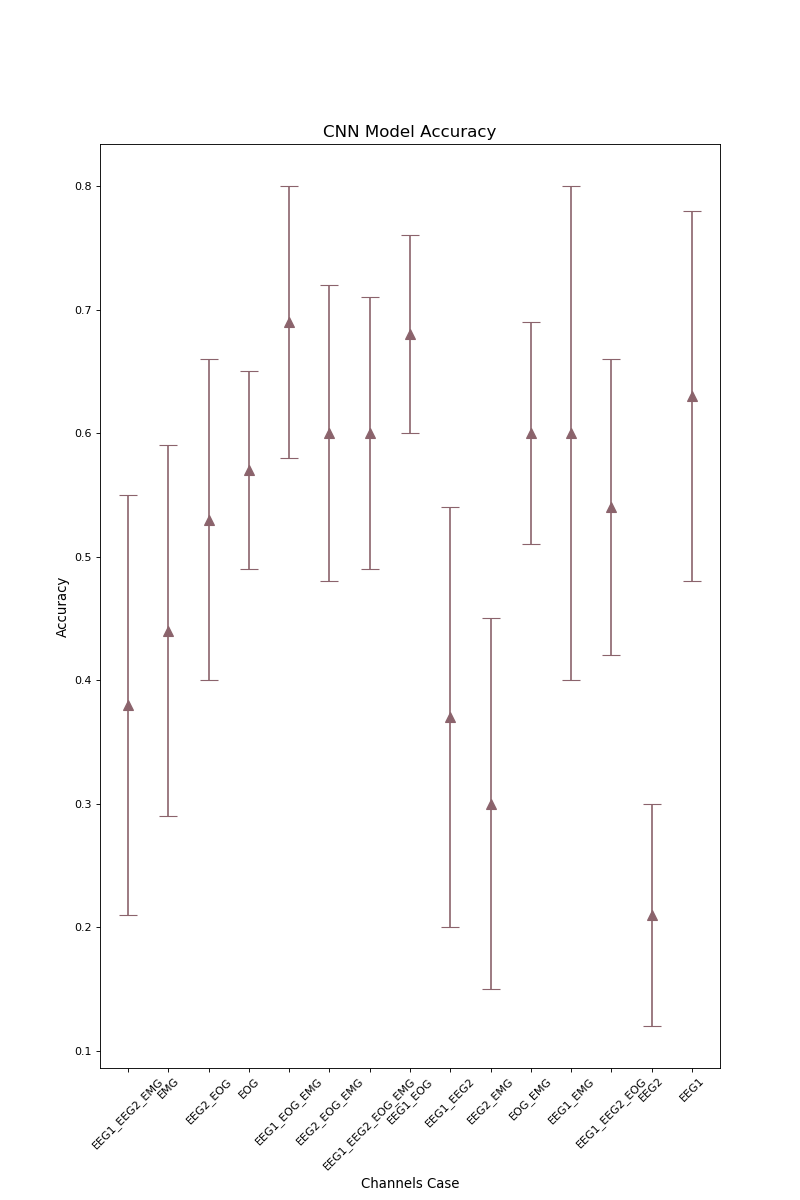

In [22]:
channels = model_cnn_metrics.keys()
fig, ax = plt.subplots(figsize=(10,15))
x = np.arange(len(model_cnn_metrics.keys()))
ax.errorbar(x , accuracy_means, yerr=accuracy_stds, linestyle='None', marker='^', capsize=8, color='#8B636C', ms=9)
plt.xticks(x, channels, rotation  = 45)  
plt.title('CNN Model Accuracy', fontsize=15)
plt.xlabel('Channels Case', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.show()